## LeNet Architecture

<img src='http://drive.google.com/uc?export=view&id=1MevERvWOuYttJyTaFbGDJggB3luPD0TP' /><br>

LeNet-5는 32x32 크기의 흑백 이미지에서 학습된 7 layer Convolutional Neural Network  

[Conv(C1) - Subsampling(S2) - Conv(C3) - Subsampling(S4) - Conv(C5) - FC - FC]  

**Input**  
입력 이미지는 32x32  
**Layer C1**  
5x5 크기의 kernel 6개와 stride=1, convolutional layer  
입력 크기는 32x32x1 이고, 출력 크기는 28x28x6  
**Layer S2**   
2x2 크기의 kernel 6개와 stride=2, subsampling layer  
입력 크기는 28x28x6 이고, 출력 크기는 14x14x6  
**Layer C3**  
5x5 크기의 kernel 16개와 stride=1, convolution layer  
입력 크기는 14x14x6 이고, 출력 크기는 10x10x16  
**Layer S4**  
2x2 크기의 kernel 16개와 stride=2, subsampling layer  
입력 크기는 10x10x16 이고, 출력 크기는 5x5x16  
**Layer C5**  
5x5 크기의 kernel 120개와 stride=1, convolutional layer  
입력 크기는 5x5x16 이고, 출력 크기는 1x1x120  
**Layer F6**  
tanh 함수를 활성화 함수로 이용하는 fully-connected layer  
입력 유닛은 120개 이고, 출력 유닛은 84개  
**Layer F7**  
RBF(Euclidean Radia Basis Function unit)를 활성화 함수로 이용하는 output layer  
입력 크기는 84 이고, 출력 크기는 10  

(1) 필요한 라이브러리 import

In [1]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

(2) Parameters 설정하기

In [2]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

(3) 정확도를 구하는 function과 손실을 시각화 하는 function 정의

In [3]:
def get_accuracy(model, data_loader, device):
    '''
    전체 data_loader에 대한 예측의 정확도를 계산하는 함수
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    training과 validation loss를 시각화하는 함수
    '''
    
    # plot style을 seaborn으로 설정
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # plot style을 기본값으로 설정
    plt.style.use('default')

(4) training data에 사용되는 helper 함수 정의하기

In [4]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    training loop의 training 단계에 대한 함수
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # 순전파
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # 역전파
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

(5) validation data에 사용되는 함수 정의하기

In [5]:
#validation 단계에서는 역전파를 진행하지 않습니다.

def validate(valid_loader, model, criterion, device):
    '''
    training loop의 validation 단계에 대한 함수
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # 순전파와 손실 기록하기
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

(6) training loop 정의하기

In [6]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    전체 training loop를 정의하는 함수
    '''
    
    # metrics를 저장하기 위한 객체 설정
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # model 학습하기
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

(7) data 준비하기

In [7]:
#data는 torchvision에서 제공하는 MNIST data를 사용합니다.

# transforms 정의하기
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# data set 다운받고 생성하기
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# data loader 정의하기
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

C:\Users\rudtj\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(8) 불러온 MNIST data 확인하기

In [8]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


(9) LeNet-5 구조 정의하기

In [9]:
# No.1

class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        
        
        self.pool = nn.AvgPool2d(kernel_size=2)
        
        
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.tanh(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.tanh(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.tanh(x)
        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        
        probs = F.softmax(x, dim=1)
        return x, probs

In [10]:
# No.2

class LeNet5_Sequential(nn.Module):

    def __init__(self):
        super(LeNet5_Sequential, self).__init__()
        
        self.feature_extractor = nn.Sequential( 
            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        probs = F.softmax(x, dim=1)
        return x, probs

(10) model, optimizer, loss function 설정하기

In [11]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

(11) 신경망 학습하기

C:\Users\rudtj\anaconda3\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


23:22:42 --- Epoch: 0	Train loss: 0.2290	Valid loss: 0.1021	Train accuracy: 96.85	Valid accuracy: 96.80
23:23:01 --- Epoch: 1	Train loss: 0.0762	Valid loss: 0.0621	Train accuracy: 98.38	Valid accuracy: 98.20
23:23:19 --- Epoch: 2	Train loss: 0.0550	Valid loss: 0.0519	Train accuracy: 98.69	Valid accuracy: 98.50
23:23:39 --- Epoch: 3	Train loss: 0.0431	Valid loss: 0.0475	Train accuracy: 99.11	Valid accuracy: 98.53
23:23:59 --- Epoch: 4	Train loss: 0.0353	Valid loss: 0.0455	Train accuracy: 99.30	Valid accuracy: 98.71
23:24:19 --- Epoch: 5	Train loss: 0.0287	Valid loss: 0.0414	Train accuracy: 99.38	Valid accuracy: 98.72
23:24:40 --- Epoch: 6	Train loss: 0.0253	Valid loss: 0.0438	Train accuracy: 99.49	Valid accuracy: 98.56
23:25:00 --- Epoch: 7	Train loss: 0.0223	Valid loss: 0.0477	Train accuracy: 99.54	Valid accuracy: 98.52
23:25:19 --- Epoch: 8	Train loss: 0.0185	Valid loss: 0.0441	Train accuracy: 99.55	Valid accuracy: 98.70
23:25:38 --- Epoch: 9	Train loss: 0.0173	Valid loss: 0.0493	Trai

<ipython-input-3-eb39e4490d4d>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


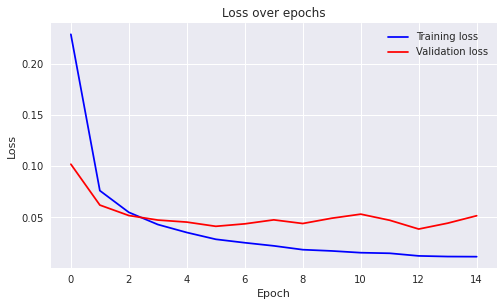

In [12]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, DEVICE)

## Alexnet Architecture

<img src='https://t1.daumcdn.net/cfile/tistory/99FEB93C5C80B5192E' /><br>

Alexnet은 3x227x227 크기의 이미지에서 학습되었으며, 2개의 GPU로 병렬연산을 수행한 8 layer Convolutional Neural Network이다.   

[Input – Conv1 – MaxPool1 – Norm1 – Conv2 – MaxPool2 – Norm2 – Conv3 – Conv4 – Conv5 – MaxPool5 – FC6- FC7- FC8(output)]  

Alexnet 구조 정의하기

In [12]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, init_weights: bool = True):
        super(AlexNet, self).__init__()
        self.fstblock_1 = nn.Sequential(
            # Input Channel (RGB: 3)
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=11, padding=0, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.LocalResponseNorm(size=5, k=2),
            nn.Conv2d(in_channels=48, out_channels=128, kernel_size=5, padding=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.LocalResponseNorm(size=5, k=2),
        )
        self.fstblock_2 = nn.Sequential(
            # Input Channel (RGB: 3)
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=11, padding=0, stride=4), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.LocalResponseNorm(size=5, k=2),
            nn.Conv2d(in_channels=48, out_channels=128, kernel_size=5, padding=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.LocalResponseNorm(size=5, k=2),
        )

        self.cross_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=96, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
        )
        self.cross_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=96, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
        )

        self.sndblock_1 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=192, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), 
        )
        self.sndblock_2 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=192, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), 
        )

        self.crossfc1_1 = nn.Sequential(
            nn.Linear(128 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )
        self.crossfc1_2 = nn.Sequential(
            nn.Linear(128 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )

        self.crossfc2_1 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )
        self.crossfc2_2 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )

        self.classifier_1 = nn.Linear(2048, num_classes)
        self.classifier_2 = nn.Linear(2048, num_classes)
    
    def forward(self, x:torch.Tensor):
        # First Block
        x1 = self.fstblock_1(x)
        x2 = self.fstblock_2(x)

        # Cross
        x3 = self.cross_conv_1(x1) # Left Block 1
        x4 = self.cross_conv_2(x2) # Left Block 2

        x5 = self.cross_conv_1(x1) # Right Block 1
        x6 = self.cross_conv_2(x2) # Right Block 2

        x1 = torch.cat([x3, x4], 1)
        x2 = torch.cat([x5, x6], 1)

        # Second Block
        x1 = self.sndblock_1(x1)
        x2 = self.sndblock_2(x2)

        x1 = torch.flatten(x1, 1)
        x2 = torch.flatten(x2, 1)

        # FC Layer (Cross)
        x3 = crossfc1_1(x1) # Left FC 1
        x4 = crossfc1_2(x2) # Left FC 2

        x5 = crossfc1_1(x1) # Right FC 1
        x6 = crossfc1_2(x2) # Right FC 2

        x1 = torch.cat([x3, x4], 1)
        x2 = torch.cat([x5, x6], 1)

        # FC Layer (Cross)
        x3 = crossfc2_1(x1) # Left FC 1
        x4 = crossfc2_2(x2) # Left FC 2

        x5 = crossfc2_1(x1) # Right FC 1
        x6 = crossfc2_2(x2) # Right FC 2

        x1 = torch.cat([x3, x4], 1)
        x2 = torch.cat([x5, x6], 1)

        x1 = classifier_1(x1)
        x2 = classifier_2(x2)

        x = (x1 + x2)/2
        return x

## VGG16 Architecture

<img src='https://blog.kakaocdn.net/dn/K990l/btqwDJ7C54R/664Ksm6gyTGBR1wK3YPDFk/img.png' /><br>

VGG16은 3x224x224 크기의 이미지에서 학습된 16 layer Convolutional Neural Network이다.   

[Input – C1 – C2 – MaxPool2 – C3 – C4 – MaxPool4 – C5 – C6 – C7 – MaxPool7 – C8 – C9 – C10 – MaxPool10 – C11 – C12 – C13 – MaxPool13 – FC14 – FC15 – FC16(Output)]     

**Input**  
입력 이미지 3x224x224  
    
**Layer C1**  
3x3 크기의 kernel 64개, stride=1, padding=1인 convolutional layer  
입력 크기는 3x224x224 이고, 출력 크기는 64x224x224  
**Layer C2**
3x3 크기의 kernel 64개, stride=1, padding=1인 convolutional layer  
입력 크기는 64x224x224 이고, 출력 크기는 64x224x224  
**Layer Maxpool2**  
2x2 크기의 kernel, stride=2인 maxpooling layer  
입력 크기는 64x224x224 이고, 출력 크기는 64x112x112  
    
**Layer C3**  
3x3 크기의 kernel 128개, stride=1, padding=1인 convolutional layer  
입력 크기는 64x112x112 이고, 출력 크기는 128x112x112  
**Layer C4**  
3x3 크기의 kernel 128개, stride=1, padding=1인 convolutional layer  
입력 크기는 128x112x112 이고, 출력 크기는 128x112x112  
**Layer Maxpool4**  
2x2 크기의 kernel, stride=2인 maxpooling layer  
입력 크기는 128x112x112 이고, 출력 크기는 128x56x56  
    
**Layer C5**  
3x3 크기의 kernel 256개, stride=1, padding=1인 convolutional layer  
입력 크기는 128x56x56 이고, 출력 크기는 256x56x56  
**Layer C6**  
3x3 크기의 kernel 256개, stride=1, padding=1인 convolutional layer  
입력 크기는 256x56x56 이고, 출력 크기는 256x56x56  
**Layer C7**  
3x3 크기의 kernel 256개, stride=1, padding=1인 convolutional layer  
입력 크기는 256x56x56 이고, 출력 크기는 256x56x56  
**Layer Maxpool7**  
2x2 크기의 kernel, stride=2인 maxpooling layer  
입력 크기는 256x56x56 이고, 출력 크기는 256x28x28  
    
**Layer C8**  
3x3 크기의 kernel 512개, stride=1, padding=1인 convolutional layer  
입력 크기는 256x28x28 이고, 출력 크기는 512x28x28  
**Layer C9**  
3x3 크기의 kernel 512개, stride=1, padding=1인 convolutional layer  
입력 크기는 512x28x28 이고, 출력 크기는 512x28x28  
**Layer C10**  
3x3 크기의 kernel 512개, stride=1, padding=1인 convolutional layer  
입력 크기는 512x28x28 이고, 출력 크기는 512x28x28  
**Layer Maxpool10**  
2x2 크기의 kernel, stride=2인 maxpooling layer  
입력 크기는 512x28x28 이고, 출력 크기는 512x14x14  
    
**Layer C11**  
3x3 크기의 kernel 512개, stride=1, padding=1인 convolutional layer  
입력 크기는 512x14x14 이고, 출력 크기는 512x14x14  
**Layer C12**  
3x3 크기의 kernel 512개, stride=1, padding=1인 convolutional layer  
입력 크기는 512x14x14 이고, 출력 크기는 512x14x14  
**Layer C13**  
3x3 크기의 kernel 512개, stride=1, padding=1인 convolutional layer  
입력 크기는 512x14x14 이고, 출력 크기는 512x14x14  
**Layer Maxpool13**  
2x2 크기의 kernel, stride=2인 maxpooling layer  
입력 크기는 512x14x14 이고, 출력 크기는 512x7x7  
    
**Layer F14**  
ReLU를 활성화 함수로 이용하는 fully connected layer  
입력 크기는 25088 이고, 출력 크기는 4096  
**Layer F15**  
ReLU를 활성화 함수로 이용하는 fully connected layer  
입력 크기는 4096 이고, 출력 크기는 4096  
**Layer F16**  
ReLU를 활성화 함수로 이용하는 output layer  
입력 크기는 4096 이고, 출력 크기는 1000  

VGG16 구조 정의하기

In [ ]:
class VGG_A(nn.Module):
    def __init__(self, num_classes: int = 1000, init_weights: bool = True):
        super(VGG_A, self).__init__()
        self.convnet = nn.Sequential(
            # Input Channel (RGB: 3)
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1), # conv1
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1), # conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224 -> 112   # maxpool2
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),  # conv3
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),  # conv4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112 -> 56   # maxpool4
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),  #conv5
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),  # conv6
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),  # conv7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28   # maxpool7

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),  # conv8
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),  # conv9
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),  # conv10
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 -> 14   # maxpool10

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),  # conv11
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),  # conv12
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),  # conv13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14 -> 7   # maxpool13
        )

        self.fclayer = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # fc14
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),  # fc15
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),  # fc16 = output
            # nn.Softmax(dim=1), # Loss인 Cross Entropy Loss 에서 softmax를 포함한다.
        )
    
    def forward(self, x:torch.Tensor):
        x = self.convnet(x)
        x = torch.flatten(x, 1)
        x = self.fclayer(x)
        return x